# Multiscroll chaotic attractor (多卷波混沌吸引子)

Multiscroll attractors also called n-scroll attractor include the Chen attractor, the Lu Chen attractor, the modified Chen chaotic attractor, PWL Duffing attractor, Rabinovich Fabrikant attractor, modified Chua chaotic attractor, that is, multiple scrolls in a single attractor.

In [1]:
import brainpy as bp
import brainpy.math as bm
import matplotlib.pyplot as plt

In [2]:
def run_and_visualize(runner, duration=100, dim=3, args=None):
  assert dim in [3, 2]
  if args is None:
      runner.run(duration)
  else: 
      runner.run(duration, args=args)

  if dim == 3:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for i in range(runner.mon.x.shape[1]):
      plt.plot(runner.mon.x[100:, i], runner.mon.y[100:, i], runner.mon.z[100:, i])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
  else:
    for i in range(runner.mon.x.shape[1]):
      plt.plot(runner.mon.x[100:, i], runner.mon.y[100:, i])
    plt.xlabel('x')
    plt.xlabel('y')
  plt.show()

## Chen attractor

The Chen system is defined as follows [1]

$$
\begin{aligned}
\frac{d x(t)}{d t} &=a(y(t)-x(t)) \\
\frac{d y(t)}{d t} &=(c-a) x(t)-x(t) z(t)+c y(t) \\
\frac{d z(t)}{d t} &=x(t) y(t)-b z(t)
\end{aligned}
$$

In [3]:
@bp.odeint(method='euler')
def chen_system(x, y, z, t, a=40, b=3, c=28):
  dx = a * (y - x)
  dy = (c - a) * x - x * z + c * y
  dz = x * y - b * z
  return dx, dy, dz

  0%|          | 0/100000 [00:00<?, ?it/s]

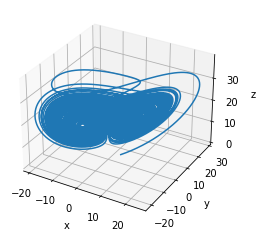

In [4]:
runner = bp.IntegratorRunner(
    chen_system,
    monitors=['x', 'y', 'z'],
    inits=dict(x=-0.1, y=0.5, z=-0.6),
    dt=0.001
)
run_and_visualize(runner, 100)

## Lu Chen attractor

An extended Chen system with multiscroll was proposed by Jinhu Lu (吕金虎) and Guanrong Chen [2].

$$
\begin{aligned}
\frac{d x(t)}{d t} &=a(y(t)-x(t)) \\
\frac{d y(t)}{d t} &=x(t)-x(t) z(t)+c y(t)+u \\
\frac{d z(t)}{d t} &=x(t) y(t)-b z(t)
\end{aligned}
$$

1. 当 u ≤-11 时，Lṻ Chen 混沌吸引子为左卷波混沌吸引子，
2. 当u 在 -10 和 10 之间 时为麻花型吸引子，
3. 当 u≥ 11 ，是右卷波混沌吸引子。

In [5]:
@bp.odeint(method='rk4')
def lu_chen_system(x, y, z, t, a=36, c=20, b=3, u=-15.15):
  dx = a * (y - x)
  dy = x - x * z + c * y + u
  dz = x * y - b * z
  return dx, dy, dz

  0%|          | 0/50000 [00:00<?, ?it/s]

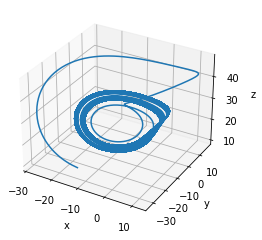

  0%|          | 0/50000 [00:00<?, ?it/s]

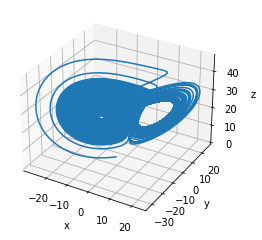

In [6]:
runner = bp.IntegratorRunner(
    lu_chen_system,
    monitors=['x', 'y', 'z'],
    inits=dict(x=0.1, y=0.3, z=-0.6),
    dt=0.002
)
run_and_visualize(runner, 100, args=dict(u=-15.15),)

runner = bp.IntegratorRunner(
    lu_chen_system,
    monitors=['x', 'y', 'z'],
    inits=dict(x=0.1, y=0.3, z=-0.6),
    dt=0.002
)
run_and_visualize(runner, 100, args=dict(u=-8),)

  0%|          | 0/50000 [00:00<?, ?it/s]

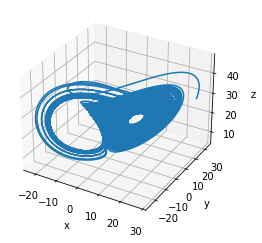

In [7]:
runner = bp.IntegratorRunner(
    lu_chen_system,
    monitors=['x', 'y', 'z'],
    inits=dict(x=0.1, y=0.3, z=-0.6),
    dt=0.002
)
run_and_visualize(runner, 100, args=dict(u=11),)

  0%|          | 0/50000 [00:00<?, ?it/s]

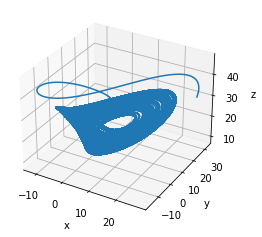

In [8]:
runner = bp.IntegratorRunner(
    lu_chen_system,
    monitors=['x', 'y', 'z'],
    inits=dict(x=0.1, y=0.3, z=-0.6),
    dt=0.002
)
run_and_visualize(runner, 100, args=dict(u=12),)

## Modified Lu Chen attractor

System equations:

$$
\begin{aligned}
\frac{d x(t)}{d t} &=a(y(t)-x(t)) \\
\frac{d y(t)}{d t} &=(c-a) x(t)-x(t) f+c y(t) \\
\frac{d z(t)}{d t} &=x(t) y(t)-b z(t)
\end{aligned}
$$

where

$$
{ f=d0z(t)+d1z(t-\tau )-d2\sin(z(t-\tau ))}
$$

In [9]:
class ModifiedLuChenSystem(bp.dyn.NeuGroup):
  def __init__(self, num, a=35, b=3, c=28, d0=1, d1=1, d2=0., tau=.2, dt=0.1):
    super(ModifiedLuChenSystem, self).__init__(num)

    # parameters
    self.a = a
    self.b = b
    self.c = c
    self.d0 = d0
    self.d1 = d1
    self.d2 = d2
    self.tau = tau
    self.delay_len = int(tau/dt)

    # variables
    self.z = bm.Variable(bm.ones(num) * 14)
    self.z_delay = bm.LengthDelay(self.z,
                                  delay_len=self.delay_len,
                                  initial_delay_data=14.)
    self.x = bm.Variable(bm.ones(num))
    self.y = bm.Variable(bm.ones(num))

    # functions
    def derivative(x, y, z, t, z_delay):
      dx = self.a * (y - x)
      f = self.d0 * z + self.d1 * z_delay - self.d2 * bm.sin(z_delay)
      dy = (self.c - self.a) * x - x * f + self.c * y
      dz = x * y - self.b * z
      return dx, dy, dz

    self.integral = bp.odeint(derivative, method='rk4')

  def update(self, tdi):
    self.x.value, self.y.value, self.z.value = self.integral(
        self.x.value, self.y.value, self.z.value, tdi.t,
        self.z_delay(self.delay_len), tdi.dt
    )
    self.z_delay.update(self.z)

  0%|          | 0/50000 [00:00<?, ?it/s]

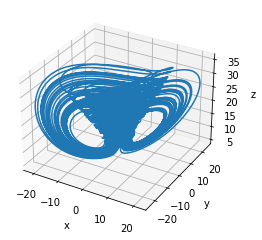

In [10]:
runner = bp.DSRunner(ModifiedLuChenSystem(1, dt=0.001),
                     monitors=['x', 'y', 'z'],
                     dt=0.001)

run_and_visualize(runner, 50)

##  Chua’s system

The classic Chua’s system is described by the following dimensionless equations [3]

$$
\begin{aligned}
&\dot{x}=\alpha(y-x)-\alpha f(x) \\
&\dot{y}=x-y+z \\
&\dot{z}=-\beta y-\gamma z
\end{aligned}
$$

where $\alpha$, $\beta$, and $\gamma$ are constant parameters and

$$
f(x)=b x+0.5(a-b)(|x+1|-|x-1|)
$$


with $a,b$  being the slopes of the inner and outer segments of $f(x)$. Note that the parameterγis usually ignored; that is, $\gamma=0$.

In [11]:
@bp.odeint(method='rk4')
def chua_system(x, y, z, t, alpha=10, beta=14.514, gamma=0, a=-1.197, b=-0.6464):
  fx = b * x + 0.5 * (a - b) * (bm.abs(x + 1) - bm.abs(x - 1))
  dx = alpha * (y - x) - alpha * fx
  dy = x - y + z
  dz = -beta * y - gamma * z
  return dx, dy, dz

  0%|          | 0/50000 [00:00<?, ?it/s]

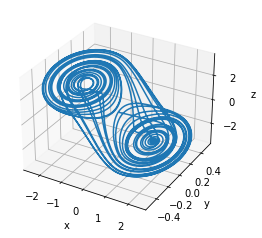

In [12]:
runner = bp.IntegratorRunner(
    chua_system,
    monitors=['x', 'y', 'z'],
    inits=dict(x=0.001, y=0, z=0.),
    dt=0.002
)
run_and_visualize(runner, 100)

  0%|          | 0/50000 [00:00<?, ?it/s]

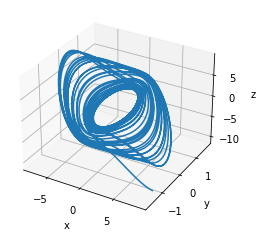

In [13]:
runner = bp.IntegratorRunner(
    chua_system,
    monitors=['x', 'y', 'z'],
    inits=dict(x=9.4287, y=-0.5945, z=-13.4705),
    dt=0.002
)
run_and_visualize(runner, 100, args=dict(alpha=8.8, beta=12.0732, gamma=0.0052, a=-0.1768, b=-1.1468),)

  0%|          | 0/50000 [00:00<?, ?it/s]

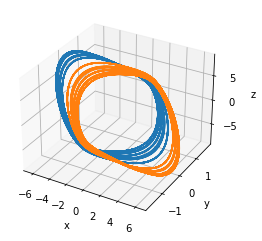

In [14]:
runner = bp.IntegratorRunner(
    chua_system,
    monitors=['x', 'y', 'z'],
    inits=dict(x=[-6.0489, 6.0489],
               y=[0.0839, -0.0839],
               z=[8.7739, -8.7739]),
    dt=0.002
)
run_and_visualize(runner, 100, args=dict(alpha=8.4562, beta=12.0732, gamma=0.0052, a=-0.1768, b=-1.1468),)

## Modified Chua chaotic attractor

In 2001, Tang et al. proposed a modified Chua chaotic system:

$$
\begin{aligned}
&\frac{d x(t)}{d t}=\alpha(y(t)-h) \\
&\frac{d y(t)}{d t}=x(t)-y(t)+z(t) \\
&\frac{d z(t)}{d t}=-\beta y(t)
\end{aligned}
$$

where 

$$
h=-b \sin \left(\frac{\pi x(t)}{2 a}+d\right)
$$

In [15]:
@bp.odeint(method='rk4')
def modified_chua_system(x, y, z, t, alpha=10.82, beta=14.286, a=1.3, b=.11, d=0):
  dx = alpha * (y + b * bm.sin(bm.pi * x / 2 / a + d))
  dy = x - y + z
  dz = -beta * y
  return dx, dy, dz

  0%|          | 0/100000 [00:00<?, ?it/s]

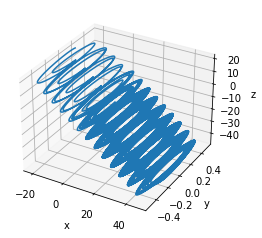

In [16]:
runner = bp.IntegratorRunner(
    modified_chua_system,
    monitors=['x', 'y', 'z'],
    inits=dict(x=1, y=1, z=0.),
    dt=0.01
)
run_and_visualize(runner, 1000)

## PWL Duffing chaotic attractor

Aziz Alaoui investigated PWL Duffing equation in 2000:

$$
\begin{aligned}
&\frac{d x(t)}{d t}=y(t) \\
&\frac{d y(t)}{d t}=-m_{1} x(t)-\left(1 / 2\left(m_{0}-m_{1}\right)\right)(|x(t)+1|-|x(t)-1|)-e y(t)+\gamma \cos (\omega t)
\end{aligned}
$$

In [17]:
@bp.odeint(method='rk4')
def PWL_duffing_eq(x, y, t, e=0.25, m0=-0.0845, m1=0.66, omega=1, i=-14):
  gamma = 0.14 + i / 20
  dx = y
  dy = -m1 * x - (0.5 * (m0 - m1)) * (abs(x + 1) - abs(x - 1)) - e * y + gamma * bm.cos(omega * t)
  return dx, dy

  0%|          | 0/100000 [00:00<?, ?it/s]

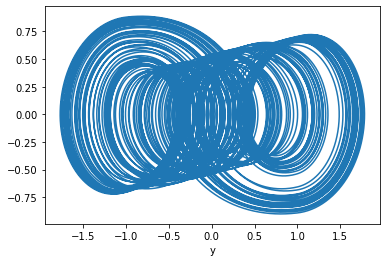

In [18]:
runner = bp.IntegratorRunner(
    PWL_duffing_eq,
    monitors=['x', 'y'],
    inits=dict(x=0, y=0),
    dt=0.01
)
run_and_visualize(runner, 1000, dim=2)

## Modified Lorenz chaotic system

Miranda & Stone proposed a modified Lorenz system:

$$
\begin{aligned}
&\frac{d x(t)}{d t}=1 / 3 *(-(a+1) x(t)+a-c+z(t) y(t))+\left((1-a)\left(x(t)^{2}-y(t)^{2}\right)+(2(a+c-z(t))) x(t) y(t)\right) \frac{1}{3 \sqrt{x(t)^{2}+y(t)^{2}}} \\
&\frac{d y(t)}{d t}=1 / 3((c-a-z(t)) x(t)-(a+1) y(t))+\left((2(a-1)) x(t) y(t)+(a+c-z(t))\left(x(t)^{2}-y(t)^{2}\right)\right) \frac{1}{3 \sqrt{x(t)^{2}+y(t)^{2}}} \\
&\frac{d z(t)}{d t}=1 / 2\left(3 x(t)^{2} y(t)-y(t)^{3}\right)-b z(t)
\end{aligned}
$$


In [19]:
@bp.odeint(method='euler')
def modified_Lorenz(x, y, z, t, a=10, b=8 / 3, c=137 / 5):
  temp = 3 * bm.sqrt(x * x + y * y)
  dx = (-(a + 1) * x + a - c + z * y) / 3 + ((1 - a) * (x * x - y * y) + (2 * (a + c - z)) * x * y) / temp
  dy = ((c - a - z) * x - (a + 1) * y) / 3 + (2 * (a - 1) * x * y + (a + c - z) * (x * x - y * y)) / temp
  dz = (3 * x * x * y - y * y * y) / 2 - b * z
  return dx, dy, dz

  0%|          | 0/100000 [00:00<?, ?it/s]

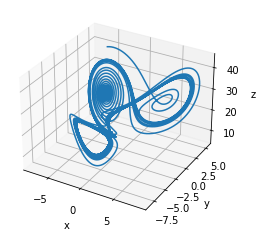

In [20]:
runner = bp.IntegratorRunner(
    modified_Lorenz,
    monitors=['x', 'y', 'z'],
    inits=dict(x=-8, y=4, z=10),
    dt=0.001
)
run_and_visualize(runner, 100, dim=3)

## References

- [1]  CHEN, GUANRONG; UETA, TETSUSHI (July 1999). "Yet Another Chaotic Attractor". International Journal of Bifurcation and Chaos. 09 (7): 1465–1466.
- [2] Chen, Guanrong; Jinhu Lu (2006). "Generating Multiscroll Chaotic Attractors: Theories, Methods and Applications" (PDF). International Journal of Bifurcation and Chaos. 16 (4): 775–858. Bibcode:2006IJBC...16..775L. doi:10.1142/s0218127406015179. Retrieved 2012-02-16.
- [3] L. Fortuna, M. Frasca, and M. G. Xibilia, “Chuas circuit implementations: yesterday, today and tomorrow,” World Scientific, 2009.